In [3]:
import numpy as np
import scipy.signal
from scipy.optimize import minimize
from datetime import datetime
from fur.one_data_set_analyzer import analyze_one_dataset
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
import seaborn as sns
import sys
import os
from fur.path_assistant import PathAssistant
shift = PathAssistant('shift_03_16_2020',
    ignore_files=['RefCurve_2020-03-16_0_084020_test.Wfm.bin',
                  'RefCurve_2020-03-16_153_155200.Wfm.bin'])
results_dir = shift.get_results_dir()
from fur.extending_with_acnet_data import get_fluctuations_df_with_acnet_data
fluctuations_df = get_fluctuations_df_with_acnet_data(
    shift,
    "res_df_comb_filter_no_nd_filters_ROUND_LONG_data_03_16_2020.csv",
    "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt"
)
from config import get_from_config
res_df = fluctuations_df


In [4]:
fluctuations_df

,waveform_file,ch2_amplitude,var_of_ch1_amplitude,noise_var,file_datetime,rounded_bpm_file_datetime,N:IWCMI,N:IBEAMA,N:IWCMBE,N:IWCMBR,...,N:ITC2LSV,N:ITC1LSV,N:IWCMI_recalibrated_to_IWCMI_absolute,N:IBEAM_recalibrated_to_IWCMI_absolute,Sigma_um_X,Sigma_um_X_err,Sigma_um_Y,Sigma_um_Y_err,Angle_spread_rad_X,Angle_spread_rad_Y
0,RefCurve_2020-03-16_102_150246.Wfm.bin,0.296832,1.007318e-08,8.283207e-08,2020-03-16 15:02:46,2020-03-16 13:06:11,-2.021617,-1.850993,26.781082,29.044425,...,178.666305,526.462005,-1.788250,-1.789423,249.558211,inf,230.149735,85.784969,1.801701e+07,0.000181
1,RefCurve_2020-03-16_103_150321.Wfm.bin,0.255803,9.439885e-09,8.451138e-08,2020-03-16 15:03:21,2020-03-16 13:24:44,-3.004845,-2.728245,29.999293,32.415922,...,73.463303,143.077300,-2.657979,-2.637495,278.527100,inf,84.794264,23.729977,1.801701e+07,0.000067
2,RefCurve_2020-03-16_104_150359.Wfm.bin,0.220766,5.977075e-09,8.313565e-08,2020-03-16 15:03:59,2020-03-16 13:25:06,-2.889952,-2.629415,29.922572,32.333176,...,72.676201,138.576710,-2.556349,-2.541953,277.816127,inf,83.341714,23.035509,1.801701e+07,0.000066
3,RefCurve_2020-03-16_105_150432.Wfm.bin,0.197968,5.294372e-09,8.347271e-08,2020-03-16 15:04:32,2020-03-16 13:25:34,-2.752064,-2.508245,29.895756,32.367826,...,71.544296,133.097200,-2.434378,-2.424813,278.113847,inf,81.446989,22.186790,1.801701e+07,0.000064
4,RefCurve_2020-03-16_106_150502.Wfm.bin,0.180416,4.255983e-09,8.372021e-08,2020-03-16 15:05:02,2020-03-16 13:26:01,-2.626225,-2.393660,29.901546,32.384077,...,70.375000,128.287805,-2.323065,-2.314040,278.253482,inf,79.531561,21.397810,1.801701e+07,0.000063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,RefCurve_2020-03-16_163_155448.Wfm.bin,0.282003,1.070048e-08,8.345287e-08,2020-03-16 15:54:48,2020-03-16 13:59:17,-1.452991,-1.329490,25.424182,27.687879,...,157.404710,473.435940,-1.285264,-1.285267,237.902374,inf,220.633137,80.233362,1.801701e+07,0.000173
61,RefCurve_2020-03-16_164_155504.Wfm.bin,0.265667,1.160280e-08,8.466696e-08,2020-03-16 15:55:04,2020-03-16 13:59:56,-1.393888,-1.278170,25.317822,27.478391,...,156.974810,470.797910,-1.232984,-1.235654,236.102391,inf,220.037245,80.150238,1.801701e+07,0.000173
62,RefCurve_2020-03-16_165_155516.Wfm.bin,0.251659,8.472997e-09,8.349628e-08,2020-03-16 15:55:16,2020-03-16 14:00:23,-1.353276,-1.245415,25.141379,27.379898,...,155.792150,467.759350,-1.197059,-1.203989,235.256108,inf,218.847197,79.811046,1.801701e+07,0.000172
63,RefCurve_2020-03-16_166_155534.Wfm.bin,0.237287,8.997487e-09,8.380309e-08,2020-03-16 15:55:34,2020-03-16 14:00:52,-1.311657,-1.207075,24.973080,27.190384,...,155.945300,466.867400,-1.160245,-1.166924,233.627744,inf,218.494860,79.383482,1.801701e+07,0.000172


In [2]:
alpha = 1.6e-19/2e-12*np.sqrt(2)/4
alpha

2.8284271247461904e-08

In [3]:
reg = linear_model.LinearRegression(fit_intercept=False)
x1 = np.insert(res_df["ch2_amplitude"].values,0,0)
x2 = x1**2
y = np.insert(res_df["var_of_ch1_amplitude"].values,0,0)-alpha*x1
reg.fit(x2.reshape((len(x2), 1)), y)
a = reg.coef_[0]
Mf = np.sqrt(2)/(4*a)
Mf

17302325.964741554

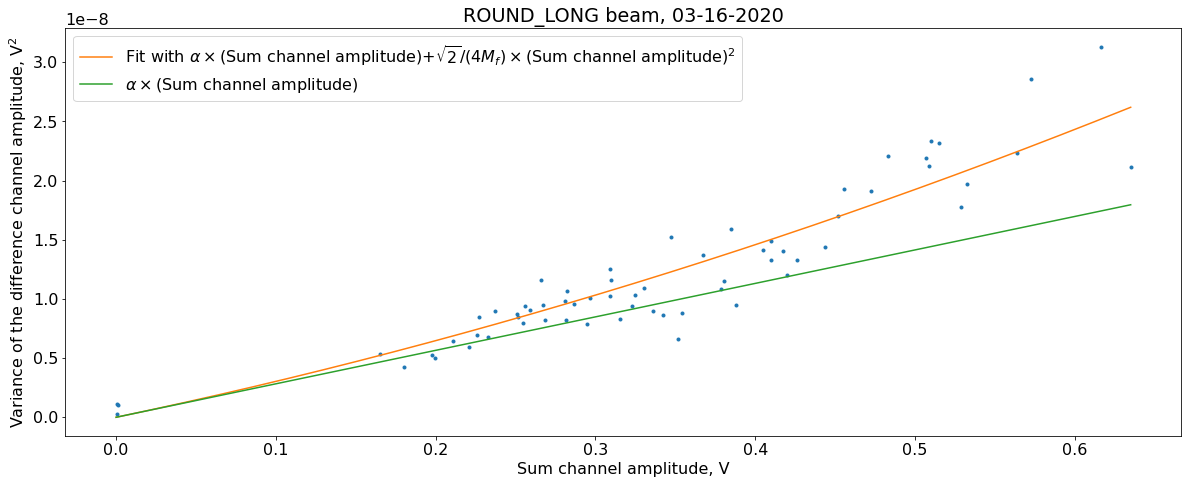

In [6]:
plt.plot(res_df["ch2_amplitude"],res_df["var_of_ch1_amplitude"] ,'.')
x_f = np.linspace(0,max(x1),1000)
plt.plot(x_f, alpha*x_f+a*x_f**2, label=r"Fit with $\alpha\times$(Sum channel amplitude)+$\sqrt{2}/(4M_f)\times$(Sum channel amplitude)$^2$")
plt.plot(x_f, alpha*x_f, label=r"$\alpha\times$(Sum channel amplitude)")
plt.xlabel("Sum channel amplitude, V")
plt.ylabel("Variance of the difference channel amplitude, V$^2$")
plt.title(r"ROUND_LONG beam, 03-16-2020")
plt.legend()
plt.show()

$\alpha=\frac{\sqrt{2}e}{4 C_f}$,
it is the predicted slope for the quantum Poisson contribution. - This estimation doesn't take into account attenuation and dispersion in the cable yet. When they are taken into account the agreement might get even better.
$M_f$ is the numer of coherent modes, according to the least squares fit.

$M_f = 4.1\times 10^6$

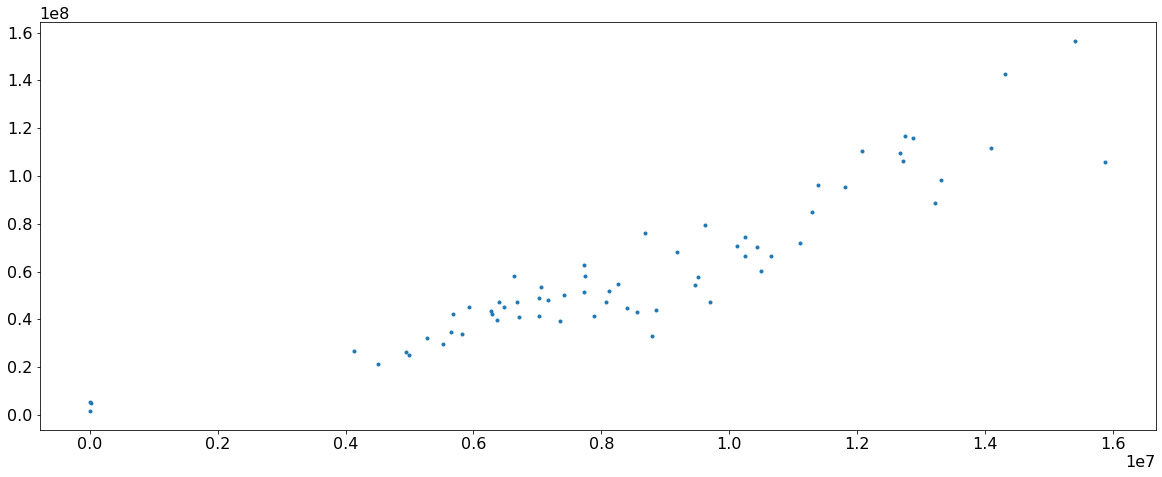

In [5]:
varN = 1/alpha**2*4*res_df["var_of_ch1_amplitude"].values
N = 1/alpha/np.sqrt(2)*res_df["ch2_amplitude"].values
plt.plot(N,varN,'.')
plt.show()